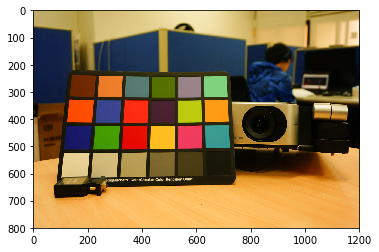

In [19]:
%matplotlib inline
import PIL as PIL
import numpy as np
import matplotlib.pyplot as plt
im = PIL.Image.open('input1.bmp')

im = np.asarray(im)
plt.imshow(im)
plt.show()

In [20]:
im_norm = im/255.0
def inv_gamma_fun(a):
    if a<=0.04044:
        return a/12.92
    else:
        return np.power((a+0.055)/(1+0.055),2.4)
def gamma_fun(a):
    if a<=0.00313:
        return a*12.92
    else:
        return (1+0.055)*np.power(a,1/2.4)-0.055
inv_gamma = np.vectorize(inv_gamma_fun)
im_ungamma = inv_gamma(im_norm)

### Scaling monitor R, G,  B
*****
先利用黑灰白三點擬合2次曲線，其中黑灰白為以下三點
* white point : (545,157)
* black point : (555,682)
* gray point : (555,355)
555 460
***
參考點的黑灰白
* white  #f3f3f2 (243,243,242)
* black  #343434 (54,54,54)
* gray   #a0a0a0 (160,160,160)

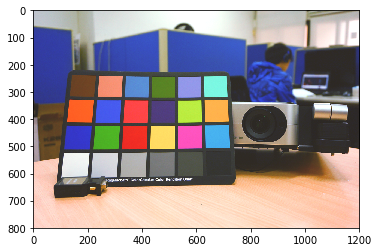

In [22]:
def T_transform(image,T):
    im_transform = np.zeros(image.shape)
    trans_im = np.transpose(image,(2,1,0))
    trans_im = np.reshape(trans_im,(3,im.shape[0]*im.shape[1]))
    im_transform = np.transpose(np.reshape(np.dot(T,trans_im),(3,im.shape[1],im.shape[0])),(2,1,0))

    return im_transform
white_point = im[545][157]
black_point = im[555][682]
gray_boint = im[555][460]
white_point_ref = [243,243,242]
black_point_ref = [54,54,54]
gray_boint_ref = [122,122,121]
poly_x = np.zeros((3,3))
poly_y = np.zeros((3,3))
poly_c = np.zeros((3,3))
poly_degree = 2
im_balance = np.zeros(im.shape)
for i in range(3):
    poly_x[i] = np.array([white_point[i],black_point[i],gray_boint[i]])
    poly_y[i] = np.array([white_point_ref[i],black_point_ref[i],gray_boint_ref[i]])
    poly_c[i] = np.polyfit(poly_x[i],poly_y[i],poly_degree)
    im_balance[:,:,i] = np.polyval(poly_c[i],im[:,:,i])

# Scaling_Matrix = np.zeros((3,3))
# Scaling_Matrix[range(Scaling_Matrix.shape[0]),range(Scaling_Matrix.shape[1])] = 255.0/(im[545][157]-im[555][682])
# im_scaleRGB = T_transform(im,Scaling_Matrix)
im_balance[im_balance>255] = 255
im_balance[im_balance<0] = 0

plt.imshow(np.around(im_balance).astype(np.uint8))
plt.show()

In [17]:
P = np.array([[0.4124,0.3576,0.1805],
              [0.2126,0.7152,0.0722],
              [0.0193,0.1192,0.9505]])
P_inv = np.linalg.inv(P)

im_xyz = T_transform(im_ungamma,P)
# trans_im = np.transpose(im_ungamma,(2,1,0))
# trans_im = np.reshape(trans_im,(3,im.shape[0]*im.shape[1]))
# im_xyz = np.transpose(np.reshape(np.dot(P,trans_im),(3,im.shape[1],im.shape[0])),(2,1,0))

# trans_im.shape

## “wrong von Kries” transformation


In [18]:
im_xyz[545][157]

array([ 0.61262392,  0.64087404,  0.37158204])

* white color checker : (0.8829,0.9,1.06)
* black color checker : (0.0304,0.031,0.036689)
* gray color checker : (0.8829,0.9,1.06)

In [25]:
wrong_K_T = np.zeros((3,3))
wrong_K_T2 = np.zeros((3,3))
p_white_xyz = np.array([0.8829,0.9,1.06])
p_black_xyz = np.array([[0.0304,0.031,0.036689]])
wrong_K_T[range(wrong_K_T.shape[0]),range(wrong_K_T.shape[1])] = np.divide(p_white_xyz,im_xyz[545][157])

im_balance_xyz = T_transform(im_xyz,wrong_K_T)
# wrong_K_T2[range(wrong_K_T2.shape[0]),range(wrong_K_T2.shape[1])] = np.divide(p_black_xyz,im_xyz[555][682])
# im_balance_xyz = T_transform(im_balance_xyz,wrong_K_T2)

In [1]:
im_balance_lrgb = T_transform(im_balance_xyz,P_inv)

gamma = np.vectorize(gamma_fun)
im_gamma_srgb = gamma(im_balance_lrgb)
output = im_gamma_srgb*255
output[output>255] = 255
output[output<0] = 0
plt.imshow(output.astype(np.uint8))
plt.show()

NameError: name 'T_transform' is not defined

## Von Kries's method

In [1]:
T_LMS = np.array([
    [.8951,.2664,-0.1614],
    [-0.7502,1.7135,.0367],
    [.0389,.0685,1.0296]
])
T_LMS_inv = np.linalg.inv(T_LMS)

NameError: name 'np' is not defined

In [1]:
im_lms = T_transform(im_xyz,T_LMS)

NameError: name 'T_transform' is not defined

In [32]:
im_lms[545][157]

array([ 0.65911517,  0.65218426,  0.45031181])

In [33]:
LMS_balance = np.zeros((3,3))
LMS_balance[range(3),range(3)] = 1.0/im_lms[545][157]

In [34]:
im_lms_balance = T_transform(im_lms,LMS_balance)
im_balance_xyz = T_transform(im_lms_balance,T_LMS_inv)

In [35]:
im_balance_lrgb = T_transform(im_balance_xyz,P_inv)

gamma = np.vectorize(gamma_fun)
im_gamma_srgb = gamma(im_balance_lrgb)

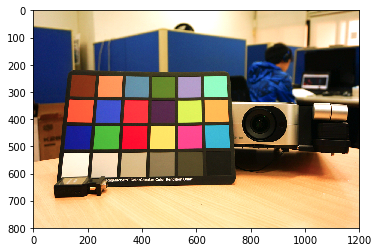

In [36]:
output = im_gamma_srgb*255
output[output>255] = 255
output[output<0] = 0
plt.imshow(output.astype(np.uint8))
plt.show()

In [85]:
P_inv

array([[ 3.24062548, -1.53720797, -0.4986286 ],
       [-0.96893071,  1.87575606,  0.04151752],
       [ 0.05571012, -0.20402105,  1.05699594]])